# Predicting the stock price of next 5 minutes

We train a one dimensional convolution network to predict the average price of a stock in the next 5 minutes. The input to the model are previous minutely candle bars.

*This is a very simple model, and is not intended to be used for actual trading. The purpose of the project is to illustrate how to train a simple stock price predictor, discuss the implementation details and analyze performance of the model.*

### Train the model

Run `minutely_stocks.py` to train the model

## Model architecture and setup

#### Dataset `dataset.py`

Broadly, our model takes a few minutely candle bars as input and predicts the average price for the next 5 minutes. A candle bar is the high, low, open, close prices for that minute and the volume for that minute.

First. divide all the candle bar prices by the mean price of the day before and the candle bar volume by mean volume per minute the day before. This is defined in function `normalize_by_previous_day`. This normalizes the prices and volumes across all days. This way the model sees the price and volume relative to the previous day. It might be better to normalize volume by the mean volume across a few previous days.

Next we take logarithms (natural) of prices and volumes. We used logs because that generally makes more sense in most financial numbers where you should be looking at percentage differences than absolute differences.

Target is the difference between mean of the next five minutes and mean of the previous minutes.

$$y_t = \sum_{i=1}^5 \log{p_{t + i}} - \sum_{i=1}^5 \log{p_{t - i - 1}}$$ 

where $p_t$ is the price at the $t^{th}$ minute. We take geometric mean between open and close prices of a minute as the average price at a minute; that is $\log{p_t} = \frac{\log{open_t} + \log{close_t}}{2}$

We predict the difference between 5 minute averages to reduce noise in the target. You can also try predicting the price of the next minute relative to previous minute or even the price of the next minute relative to the closing price of previous minute. But these short term values have a lot of noise which makes it harder for the model to train. You can also try to train the model to make multiple predictions.

We split the data into training and validation. We take the last 100 days for validation.
Finally, we normalize all the prices by the mean and standard deviation of training data prices. We normalize all the volumes by mean, standard deviation of training data volumes. We also normalize the targets ($y_t$ by the mean and standard deviation of training data targets. This normalization is important to for the model to train to efficiently with default hyper-parameters, such as weight initializations, learning rates, etc.

#### Model `model.py`

The convolution network slides over all minutes of the day and outputs the predictions at each minute.

The model consists of three 1-D convolution layers with no pooling. The sizes of the layers can be configured. The kernel sizes of the convolution layers determine how many previous minutes of data the model sees when it predicts the average price of next five minutes.

`FrontPaddedConv1d` adds a left padding of `kernal_size - 1` to the input. That is the input and output lengths of the layer are equal, and each output has a visibility range of `kernal_size` to the left.

## Analytics

The model we trained gets 5 candle bars as inputs five previous candle bars. We also trained a smaller model that gets 2 candle bars as input.

In [2]:
from labml import analytics
import numpy as np
from IPython.display import Image

In [3]:
ind = analytics.runs('8b1622622a4f11eb839a932ba9d2c722')

Let see how the training loss and validation loss have progressed over time.

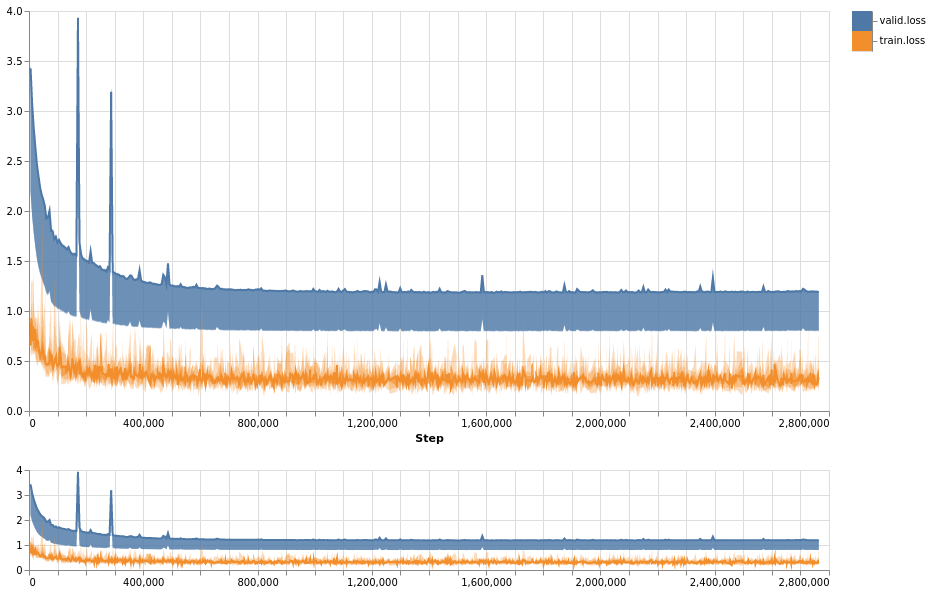

In [14]:
analytics.distribution(ind.loss_valid + ind.loss_train, width=700, height=300)
# Image(filename='images/losses.png') 

Here's the comparison with the smaller model.

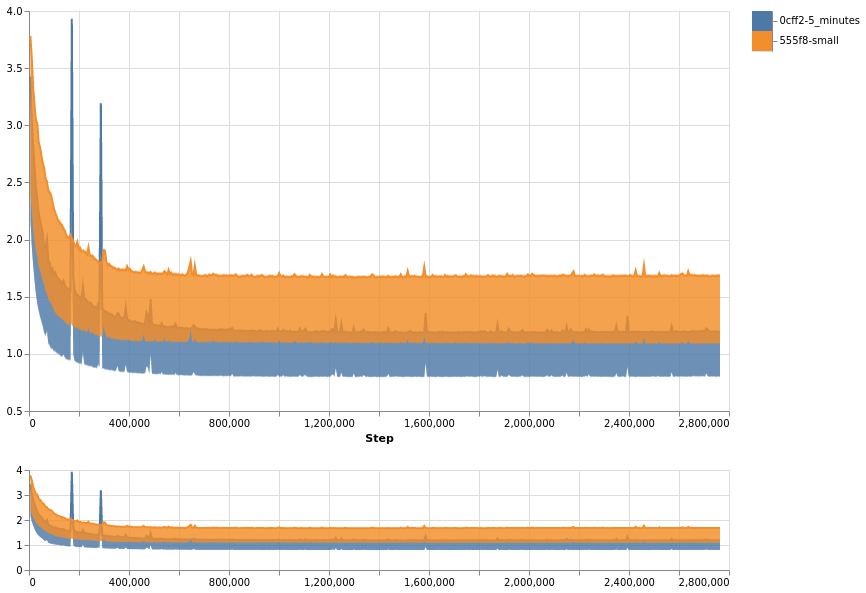

In [15]:
small = analytics.runs('8b1622622a4f11eb839a932ba9d2c722')
analytics.distribution((ind + small).loss_valid, width=700)
# Image(filename='images/small.png') 

It is easier to interpret the results with a scatter plot of targets and predictions of the model.
However in this case, since there are so many data points, a binned heat map is more suitable.
The X axis is the target, and Y axis is predicted.

In [7]:
series, names = analytics.artifact_data((ind.output_valid + ind.target_valid + ind.ref_valid
                                        + ind.strike_low_valid + ind.strike_high_valid))
predictions, target, ref, strike_low, strike_high = series
last_prediction = predictions[-1][1]

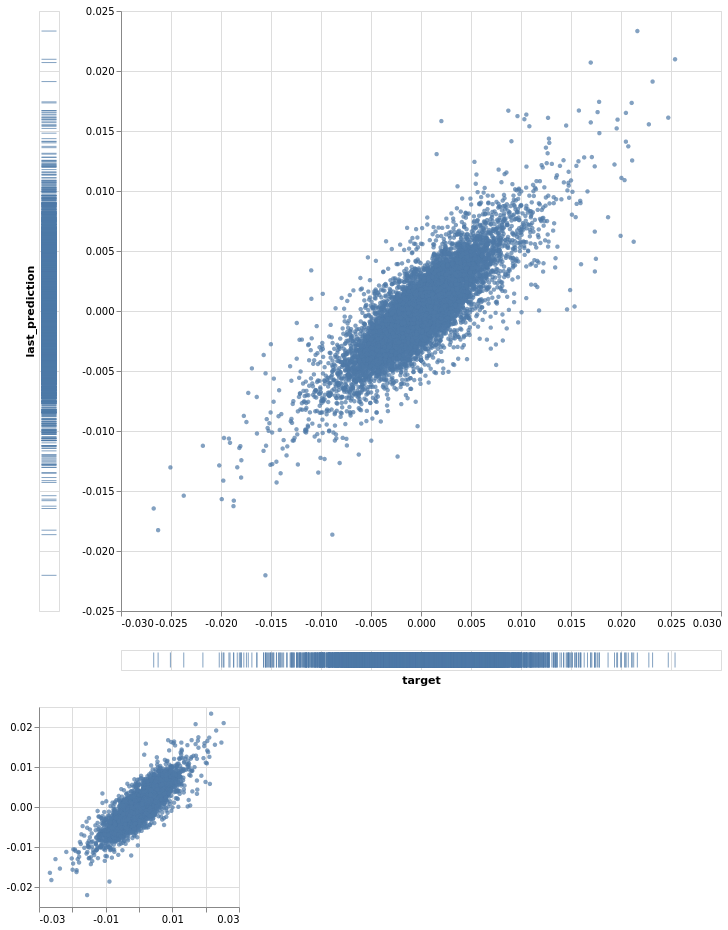

In [16]:
analytics.scatter([last_prediction.ravel()], target.ravel(),
                  names=['last_prediction'],
                  x_name='target',
                  height=600, width=600, height_minimap=200)
# Image(filename='images/scatter.png') 

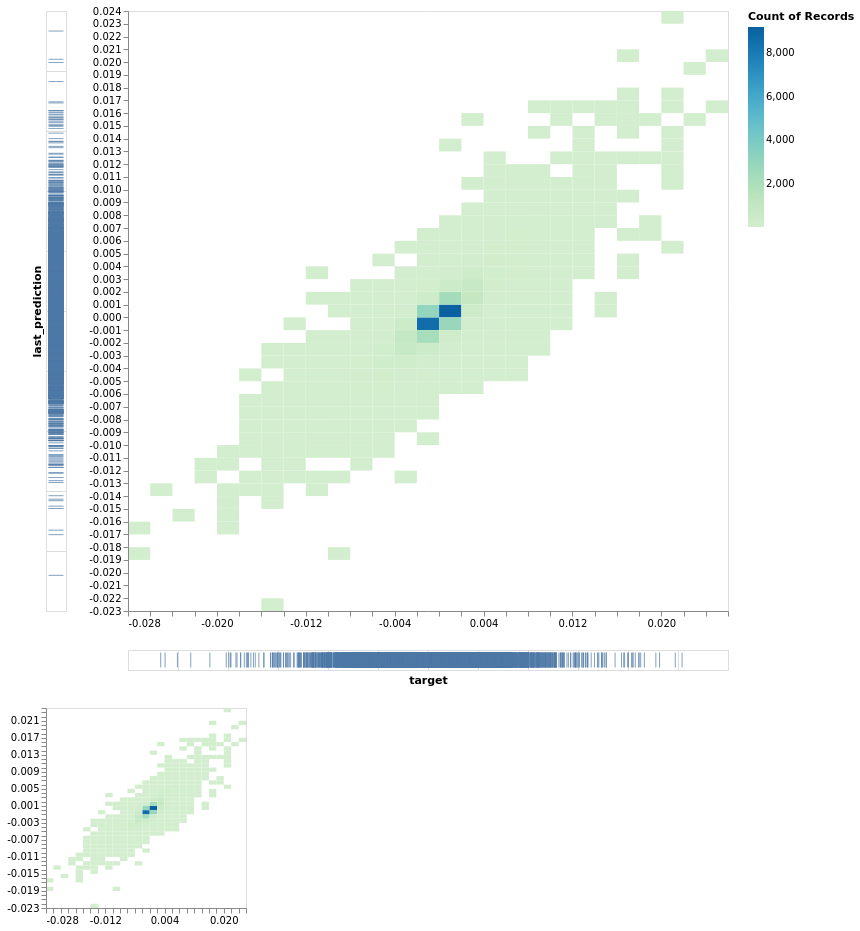

In [17]:
analytics.binned_heatmap([last_prediction.ravel()], target.ravel(),
                  names=['last_prediction'],
                  x_name='target',
                  height=600, width=600, height_minimap=200)
# Image(filename='images/heatmap.png') 

Here we can see that the model has been able to predict with a decent accuracy, while there are some false positives and false negatives.

The actual performance of the model depends on price at you make a decision to buy or sell, which we call strike price. The above chart makes sense if the strike price was independent, but it is not. So the we should plot the average price in next 5 minutes / strike price. Lets assume the strike price is geometric mean of low and high of the next minute.

We plot the actual and predicted gains per dollar invested.

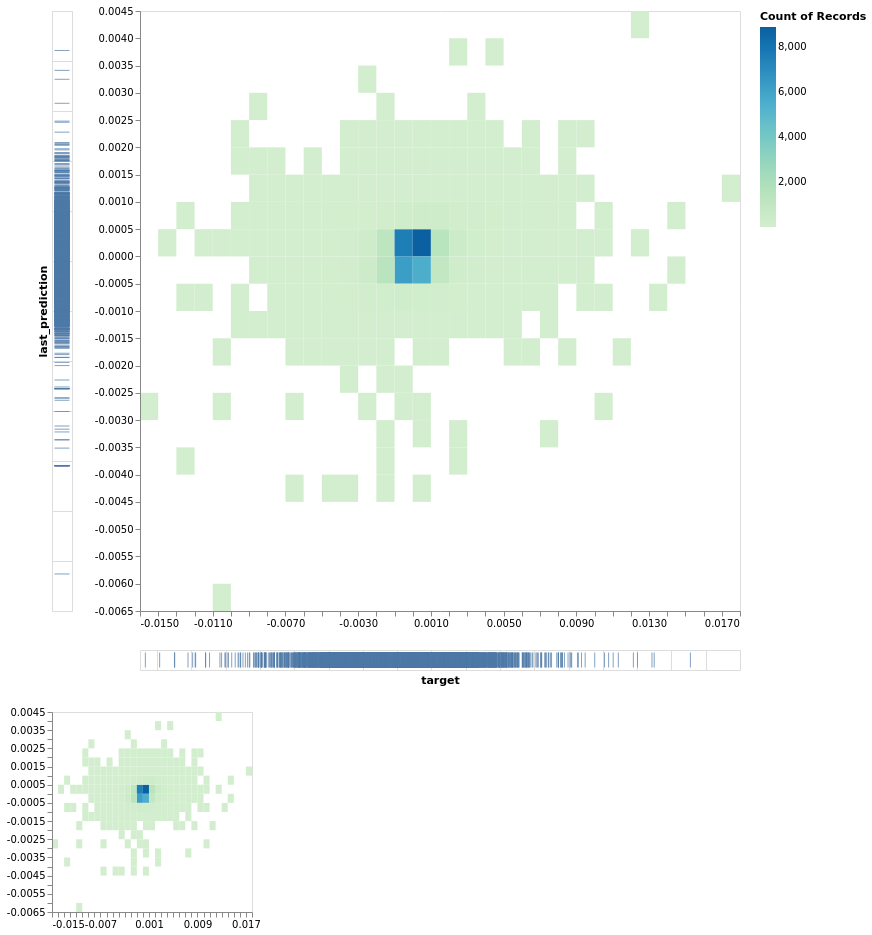

In [18]:
actual_gain = np.exp(target + ref - (strike_low + strike_high) / 2) - 1
predicted_gain = np.exp(last_prediction + ref - (strike_low + strike_high) / 2) - 1

analytics.binned_heatmap([predicted_gain.ravel()], actual_gain.ravel(),
                  names=['last_prediction'],
                  x_name='target',
                  height=600, width=600, height_minimap=200)
# Image(filename='images/heatmap_strike.png') 

Let's calculate the total gain if we invested `$1.00` every time the prediction was positive. Note, that this is not the cumulative gain.

In [11]:
np.sum((predicted_gain > 0) * actual_gain)

0.12962162

To get a better understanding on the gains, we can plot gains for a range of strike prices between low and high of the next immediate minute.

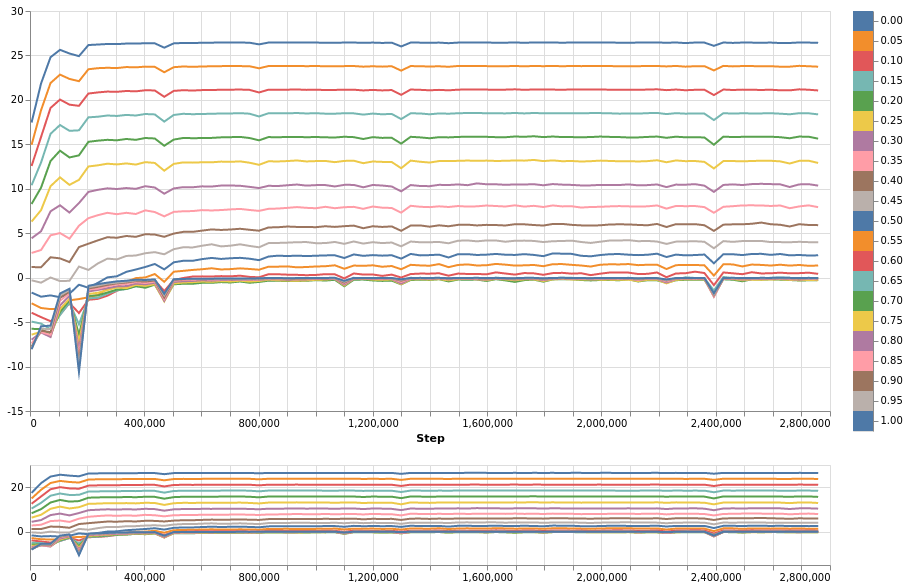

In [19]:
steps = np.array([v[0] for v in predictions])
gains = []
for ratio in np.arange(0, 1.01, 0.05):
    g = []
    for i in range(len(steps)):
        strike = (strike_low * (1 - ratio) + strike_high * ratio)
        ap = np.exp(target + ref - strike) - 1
        pp = np.exp(predictions[i][1] + ref - strike) - 1
        g.append(np.sum(ap * (pp > 0)))
    gains.append(np.array(g))
    
analytics.distribution(gains, steps, names=[f'{n :.2f}' for n in np.arange(0, 1.01, 0.05)])
# Image(filename='images/gains.png') 

In the above chart we can see how much money we can be making if we were able decide and buy at different intervals between low and high.

*These numbers are too good to be true and in fact they are. The strike price will probably be positioned adversely and as we can see from the above binned heat-map our model is not very accurate - which will lose a lot of money. We also made an untested assumption that we can sell at average price of the next 5 minutes. Also if you try trading there will be a slippage between the last price you see and the actual price you can buy at.*

You can understand how fragile the model is if you start looking at the mean gains per trade.

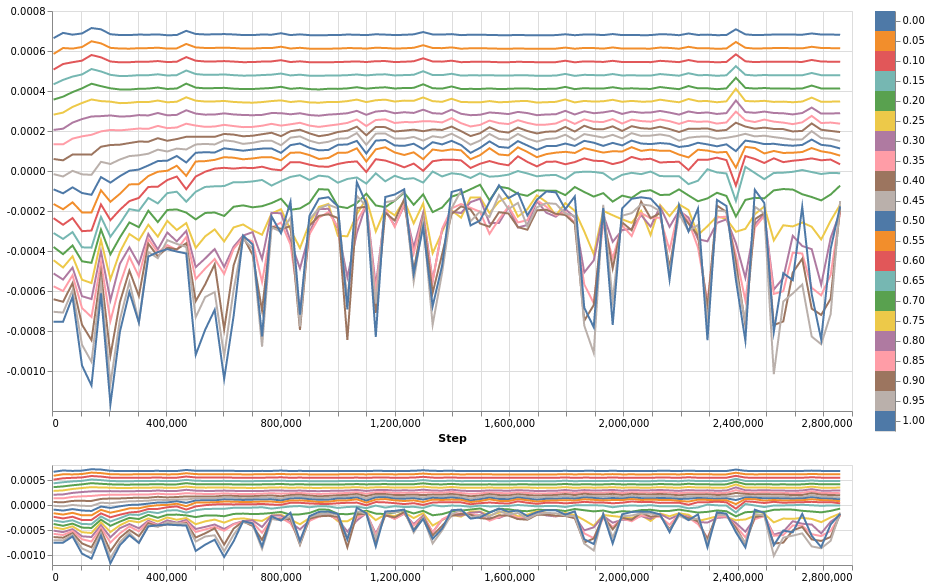

In [20]:
gains = []
for ratio in np.arange(0, 1.01, 0.05):
    g = []
    for i in range(len(steps)):
        strike = (strike_low * (1 - ratio) + strike_high * ratio)
        ap = np.exp(target + ref - strike) - 1
        pp = np.exp(predictions[i][1] + ref - strike) - 1
        g.append(np.sum(ap * (pp > 0)) / np.sum(pp > 0))
    gains.append(np.array(g))
    
analytics.distribution(gains, steps, names=[f'{n :.2f}' for n in np.arange(0, 1.01, 0.05)])
# Image(filename='images/gains_mean.png') 

The gains seem to be between `0.07%` and `-0.03%` at best. So even a slippage of `0.01%` (or `$ 1.00` slippage for a `$ 10,000` trade) could cause most or all of the gains to vanish.

If someone wants there are a bunch of improvements they could try. For instance, since we want to have a high precision but not a high recall, a modified loss function that penalizes false positives more would be better. More granular data like individual trades would probably be more useful.